## <h><center>Тема “Обучение с учителем"<center><h>

#### Подгрузим необходимые библиотеки на зададим общие настройки для отрисовки

In [7]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'figure.figsize': (8, 6), 'font.size': 14, 'font.family': 'Times New Roman'})
%config InlineBackend.figure_format = 'svg'

#### Задание 1
1. Импортируйте библиотеки pandas и numpy.
2. Загрузите "Boston House Prices dataset" из встроенных наборов данных библиотеки sklearn. Создайте датафреймы X и y из этих данных.
3. Разбейте эти датафреймы на тренировочные (X_train, y_train) и тестовые (X_test, y_test) с помощью функции train_test_split так, чтобы размер тестовой выборки
составлял 30% от всех данных, при этом аргумент random_state должен быть равен 42.
4. Создайте модель линейной регрессии под названием lr с помощью класса LinearRegression из модуля sklearn.linear_model.
5. Обучите модель на тренировочных данных (используйте все признаки) и сделайте предсказание на тестовых.
Вычислите R2 полученных предказаний с помощью r2_score из модуля sklearn.metrics.


In [8]:
from sklearn.datasets import load_boston

In [9]:
dataset = load_boston()
dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [10]:
feature_names = dataset['feature_names']
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [11]:
X, y = pd.DataFrame(data=dataset['data'], columns=feature_names), dataset['target']

In [12]:
X.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
121,0.07165,0.0,25.65,0.0,0.581,6.004,84.1,2.1974,2.0,188.0,19.1,377.67,14.27
110,0.10793,0.0,8.56,0.0,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00
118,0.13058,0.0,10.01,0.0,0.547,5.872,73.1,2.4775,6.0,432.0,17.8,338.63,15.37
152,1.12658,0.0,19.58,1.0,0.871,5.012,88.0,1.6102,5.0,403.0,14.7,343.28,12.12
82,0.03659,25.0,4.86,0.0,0.426,6.302,32.2,5.4007,4.0,281.0,19.0,396.90,6.72


#### Обучим модель на не предобработанных данных. Посмотрим на score на валидационной выборке

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_val)

print(f'mse : {mse(preds, y_val)}\nr^2 : {r2(preds, y_val)}')

mse : 21.51744423117691
r^2 : 0.6693702691495639


Как видно, качество модели плохое. Посмотрим теперь, что выдаст модель после предобработки данных

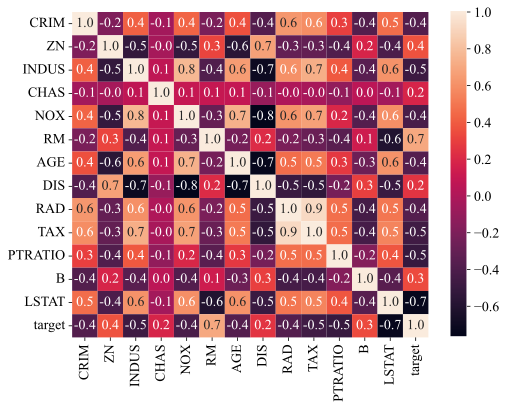

In [14]:
y = pd.Series(y, name='target')
data = pd.concat([X, y], axis=1)

sns.heatmap(data.corr(), annot=True, fmt=".1f");

#### Преоброзуем признаки, которые имеют коэффициент корреляции |corr| > 0.9 

Как видно - это TAX и RAD. Причем с другими признаками они коррелируют с одинаковыми коэффициенитами.

TAX - налоговая ставка на недвижимость; RAD - Индекс доступности к магистральным дорогам

Это наводит на мысль, что можно просто удалить один из признаков из-за переизбытка информации (Другой признак несет в себе эту информацию). Возьмем, например, RAD

In [15]:
data.drop('RAD', axis=1, inplace=True)

#### Проверим теперь данные на выбросы. 
Для этого построим ящики с усами и гистограммы

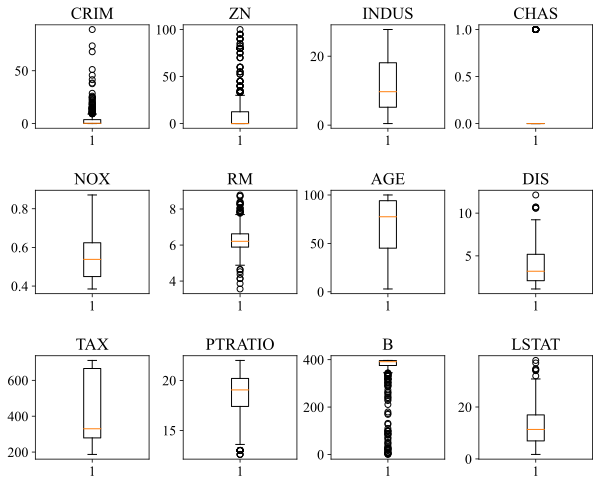

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4)
axes = axes.flatten()
for i in range(data.columns.size-1):
    col = data.columns[i]
    axes[i].boxplot(data[col])
    axes[i].set_title(f'{col}')
    
    fig.set_size_inches(10, 8)
    fig.subplots_adjust(wspace=0.3, hspace=0.6)

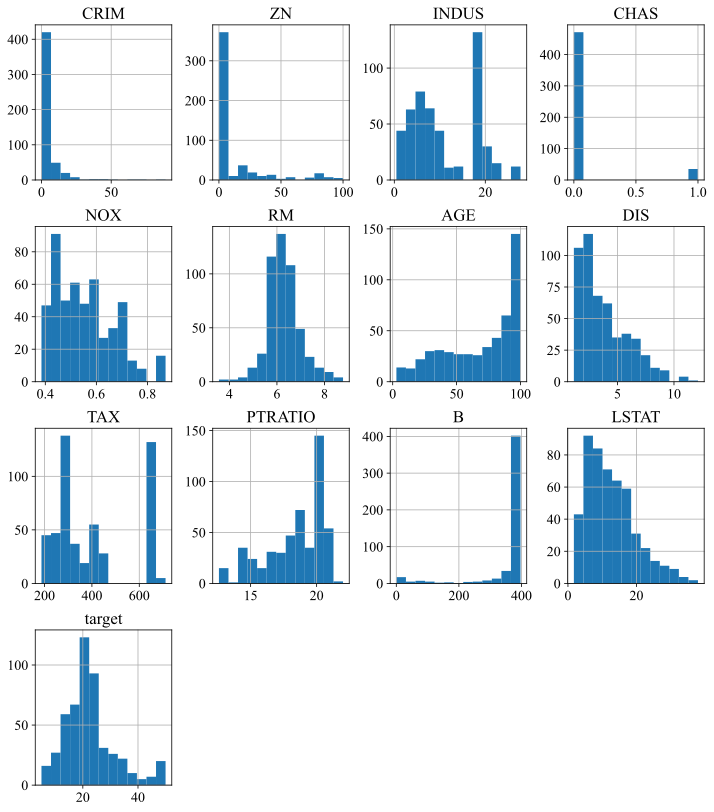

In [17]:
n_bins = int(1.72*np.power(data.shape[0], 1/3)) # Кол-во столбцов из для лучшего наблюдения (из мат. статистики)
data.hist(figsize=(12, 14), bins=n_bins);

Вопросы возикли на:

    1. CRIM - уроень преступности на душу населения, 
    2. ZN - доля земли, занятая резидентами,
    3. RM - среднее кол-во комнат в жилом помещении, 
    4. B - доля чернокожих

1. CRIM > 20 в старых городах и где большие налоги. Можно сказать, что это похоже на правду
2. Волнце такое может быть, что большие участки земли, заняты резидентами
3. data.RM.min() > 1 также data.RM.max не такой большой, что похоже на правду
4. Тоже все в порядке

#### Разделим датасет на числовие и категориальные признаки

In [18]:
categorial_features = ['CHAS']
numerical_features = data.drop(labels=['target', 'CHAS'], axis=1).columns.to_list()

dummy_features = pd.get_dummies(data[categorial_features], columns=categorial_features)

#### Разделим выборку на траин и тест

In [38]:
X, y = pd.concat([data[numerical_features], dummy_features], axis=1), data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

#### Произведем StandardScaler на данных

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

stand_train_features = scaler.fit_transform(X_train[numerical_features])
X_train[numerical_features] = stand_train_features

stand_val_features = scaler.transform(X_val[numerical_features])
X_val[numerical_features] = stand_val_features

#### Обучим модель и проверим ее точность

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_val)

print(f'mse : {mse(preds, y_val)}\nr^2 : {r2(preds, y_val)}')

mse : 23.22565175346302
r^2 : 0.6268752057388114


Как видно, качество модели ухудшилось. Значит, надо прибегнуть к другим методам :(

#### Задание 2

1. Создайте модель под названием model с помощью класса RandomForestRegressor из модуля sklearn.ensemble.


2. Сделайте агрумент n_estimators равным 1000, max_depth должен быть равен 12 и random_state сделайте равным 42.


3. Обучите модель на тренировочных данных аналогично тому, как вы обучали модель LinearRegression,
но при этом в метод fit вместо датафрейма y_train поставьте y_train.values[:, 0], чтобы получить из датафрейма одномерный массив Numpy, так как для класса RandomForestRegressor в данном методе для аргумента y предпочтительно применение массивов вместо датафрейма.


4. Сделайте предсказание на тестовых данных и посчитайте R2. Сравните с результатом из предыдущего задания.
Напишите в комментариях к коду, какая модель в данном случае работает лучше.


In [56]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)

In [57]:
model.fit(X_train, np.array(y_train));

In [58]:
preds_1 = model.predict(X_val)

In [59]:
print(f'mse : {mse(preds_1, y_val)}\nr^2 : {r2(preds_1, y_val)}')

mse : 9.290857710775612
r^2 : 0.8492733436856643


Как мы видим, качество модели заметно улучшилось. Попробуем для случайного леса подобрать наилучшие параметры с помощью поиска по сетке.

In [44]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
parameters = {'n_estimators': [500, 1000, 1500, 2000], 'max_depth': [6, 10, 12, 14, 16]}

clf = GridSearchCV(model, parameters)

In [45]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 10, 12, 14, 16],
                         'n_estimators': [500, 1000, 1500, 2000]})

In [50]:
clf.best_params_

{'max_depth': 12, 'n_estimators': 2000}

In [60]:
model1 = RandomForestRegressor(n_estimators=2000, max_depth=12, random_state=42)
model1.fit(X_train, y_train)
preds_2 = model1.predict(X_val)

In [61]:
print(f'n_estimators = 1000:\n\tmse : {mse(preds_1, y_val)}\n\tr^2 : {r2(preds_1, y_val)}\nn_estimators = 2000:\n\tmse : {mse(preds_2, y_val)}\n\tr^2 : {r2(preds_2, y_val)}')

n_estimators = 1000:
	mse : 9.290857710775612
	r^2 : 0.8492733436856643
n_estimators = 2000:
	mse : 9.439968266512814
	r^2 : 0.8462004208009556


Доп задания нет времени сделать. Сессия началась :)